In [74]:
#Imports
import torch
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch import nn
import matplotlib.pyplot as plt
import time

<h3>Config for model

In [91]:
positive_sample_size = 500
negative_sample_size = 500
window_size = 1
embedding_size = 5
num_epochs = 1000
batch_size = 50
hidden_layer_size = 500
hidden_layer_size_2 = 100

<h3>Loading first 1000 rows (500 positive, 500 negative) into data for basic model

In [92]:
positive_data = pd.read_csv('positive_sample.txt', header = None, nrows = positive_sample_size)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('negative_sample.txt', header = None, nrows = negative_sample_size)
negative_data.columns = ["Gene"]
train_data = positive_data.append(negative_data)
#print(data.head(2))

<h3>Helper methods for the model

In [93]:
#Helper methods
def get_labels():
    #labels = []
    #positive_
    labels = torch.cat((torch.ones([500, 1], dtype=torch.float), torch.zeros([500, 1], dtype=torch.float)))
    #print(labels)
    return labels
def embeddings_helper(window_size):
    vocab_set = set()
    def generate_vocab_helper(set, k): 
        n = len(set)  
        generate_vocab(set, "", n, k) 
    def generate_vocab(set, prefix, n, k): 
        if (k == 0) : 
            vocab_set.add(prefix)
            return
        for i in range(n): 
            newPrefix = prefix + set[i] 
            generate_vocab(set, newPrefix, n, k - 1) 
    def generate_embed_map(n):
        alphabet = ['0','1','2','3','4']
        generate_vocab_helper(alphabet, n)

        vocab_set_1 = sorted(vocab_set)
        vocab_map = {}

        for i in range(len(vocab_set_1)):
            vocab_map[vocab_set_1[i]] = i
        return vocab_map
    return generate_embed_map(window_size)

def return_embeddings(vocabulary):
    embeds = nn.Embedding(len(vocabulary), embedding_size)
    embeddings = {}
    for word in vocabulary:
        embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long))
    return embeddings

<h3>Creating word indexes for permutations of protein bases (words of vocabulary)

In [94]:
vocabulary = embeddings_helper(window_size)
embeddings = return_embeddings(vocabulary)
#print(len(vocabulary))

<h3>Create training data with training inputs and labels

In [95]:
list_of_tensors = []
for data in train_data.itertuples():
    gene = data.Gene
    for i in range(len(gene) - window_size + 1):
        if i == 0:
            first_tensor = embeddings[gene[i:i+window_size]]
        else:
            first_tensor = torch.cat((first_tensor, embeddings[gene[i:i+window_size]]), 0)
    list_of_tensors.append(first_tensor)
inputs = torch.stack(list_of_tensors)
labels = get_labels()

<h3> Implementing the FC Layer

In [97]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(505, hidden_layer_size)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size_2)
        #self.prelu = nn.Sigmoid()
        self.out = nn.Linear(hidden_layer_size_2, 1)
        #self.out_act = nn.Sigmoid()

    def forward(self, x):
        a1 = self.fc1(x)
        h1 = self.relu(a1)
        #dout = self.dout(h1)
        a2 = self.fc2(h1)
        h2 = self.relu(a2)
        a3 = self.out(h2)
        y = self.relu(a3)
        return y
    
def train_epoch(model, inputs, labels, optimizer, criterion, batch_size):
    model.train()
    losses = []
    for i in range(0, inputs.size(0), batch_size):
        data_batch = inputs[i:i + batch_size, :]
        labels_batch = labels[i:i + batch_size, :]
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        optimizer.zero_grad()
        # (1) Forward
        labels_hat = net(data_batch)
        # (2) Compute diff
        loss = criterion(labels_hat, labels_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        optimizer.step()        
        losses.append(loss.data.numpy())
    loss = sum(losses)/len(losses)
    return loss
    
def train_model(model, inputs, labels, optimizer, criterion, batch_size):
    losses = []
    print('Training the model:')
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        losses.append(train_epoch(model, inputs, labels, optimizer, criterion, batch_size))
#         if epoch % 25 == 0:    #print every 25 mini-batches
#             print('[%d, %5d] loss: %.9f' %
#                 (epoch + 1, epoch + 1, running_loss/len(inputs)))
#             #running_loss = 0.0
    print('Finished. Training took %.3f' %((time.time() - start_time)/60), 'minutes.')
    return losses

Training the model:
Finished. Training took 0.412 minutes.


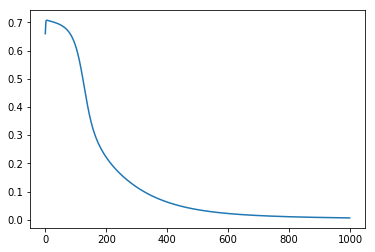

In [98]:
net = Net() # Initialize the network
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
losses = train_model(net, inputs, labels, optimizer, criterion, batch_size)
if losses != None:
    plt.plot(losses)